<h1>CS4618: Artificial Intelligence I</h1>
<h1>Overfitting and Underfitting</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [3]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "." 

<h1>Acknowledgements</h1>
<ul>
    <li>This book was helpful in the preparation of this lecture: A. G&eacute;ron: <i>Hands-On Machine Learning with Scikit-Learn, Keras &amp;
        TensorFlow (2nd edn)</i>, O'Reilly, 2019
    </li>
    <li>I based some of this notebook on some resources from Jake VanderPlas 
        (<a href="http://www.astroml.org/">http://www.astroml.org/</a>)
    </li>
</ul>

<h1>Non-Linearity</h1>
<ul>
    <li>What if the <em>true</em> relationship between the features and the target values is non-linear?</li>
    <li>A linear model may not be good enough:
        <ul>
            <li>The test error may be too high</li>
            <li>Even the training error may be too high!</li>
        </ul>
    </li>
    <li>What we need is a more <b>complex</b> model.
        <ul>
            <li>Roughly, a model is more complex if it has more parameters.</li>
            <li>E.g. quadratic functions for a dataset with just three features ($\v{x}_1$, $\v{x}_2$ and $\v{x}_3$):
                $$\v{\beta}_0 + \v{\beta}_1\v{x}_1 + \v{\beta}_2\v{x}_2 + \v{\beta}_3\v{x}_3 +
                  \v{\beta}_4\v{x}_1^2 + \v{\beta}_5\v{x}_2^2 + \v{\beta}_6\v{x}_3^2 +
                  \v{\beta}_7\v{x}_1\v{x}_2 + \v{\beta}_8\v{x}_1\v{x}_3 + \v{\beta}_9\v{x}_2\v{x}_3$$
            </li>
            <li>What would cubic functions look like (again in the case where there are just three features)?</li>
        </ul>
    </li>
</ul>

<h1>Polynomial Regression</h1>
<ul>
    <li>There are learning algorithms for non-linear models (including neural networks, see later).
    </li>
    <li>But there's a really neat trick for using a <em>linear model</em> to get some of the same effect!
        <ul>
            <li>We add extra features to our dataset.
                <ul>
                    <li>Some of the new features will be powers of the original features, e.g. a new feature 
                        $\v{x}_4 = \v{x}_1^2$.
                    </li>
                    <li>Others will be products of the original features, e.g. a new feature 
                        $\v{x}_7 = \v{x}_1\v{x}_2$ (these are often called <b>interaction features</b>).
                    </li>
                </ul>
            </li>
            <li>Then learn a <em>linear model</em> on the new dataset.</li>
        </ul>
        This is called <b>Polynomial Regression</b>.
    </li>
    <li>E.g. 
        <ul>
            <li>We want to learn models of this form:
               $$\v{\beta}_0 + \v{\beta}_1\v{x}_1 + \v{\beta}_2\v{x}_2 + \v{\beta}_3\v{x}_3 +
                  \v{\beta}_4\v{x}_1^2 + \v{\beta}_5\v{x}_2^2 + \v{\beta}_6\v{x}_3^2 +
                  \v{\beta}_7\v{x}_1\v{x}_2 + \v{\beta}_8\v{x}_1\v{x}_3 + \v{\beta}_9\v{x}_2\v{x}_3$$
            </li>
            <li>But instead we learn linear models of this form:
                $$\v{\beta}_0 + \v{\beta}_1\v{x}_1 + \v{\beta}_2\v{x}_2 + \v{\beta}_3\v{x}_3 +
                  \v{\beta}_4\v{x}_4 + \v{\beta}_5\v{x}_5 + \v{\beta}_6\v{x}_6 +
                  \v{\beta}_7\v{x}_7 + \v{\beta}_8\v{x}_8 + \v{\beta}_9\v{x}_9$$
                  but where 
                  $$\v{x}_4 = \v{x}_1^2$$
                  $$\v{x}_5 = \v{x}_2^2$$
                  $$\v{x}_6 = \v{x}_3^2$$
                  $$\v{x}_7 = \v{x}_1\v{x}_2$$
                  $$\v{x}_8 = \v{x}_1\v{x}_3$$
                  $$\v{x}_9 = \v{x}_2\v{x}_3$$
              </li>
          </ul>
      </li>
</ul>

<h2>Polynomial Regression in scikit-learn</h2>
<ul>
    <li>There's a class called <code>PolynomialFeatures</code>.</li>
    <li>We simply include it in our pipeline.</li>
</ul>

In [4]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_corkA.csv"))

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

# The features we want to select
features = ["flarea", "bdrms", "bthrms"]

# Extract the features but leave as a DataFrame
X = df[features]

# Target values, converted to a 1D numpy array
y = df["price"].values

In [5]:
linear_model = LinearRegression()

In [6]:
quadratic_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("predictor", LinearRegression())
])

<ul>
    <li>To keep the code concise, we won't do validation sets, etc.: just k-fold cross-validation on the 
        whole dataset.
    </li>
</ul>

In [7]:
# Error estimation for the linear model.
np.mean(cross_val_score(linear_model, X, y, scoring="neg_mean_absolute_error", cv=10))

np.float64(-60.79942430798836)

In [8]:
# Error estimation for the quadratic model.
np.mean(cross_val_score(quadratic_model, X, y, scoring="neg_mean_absolute_error", cv=10))

np.float64(-62.036108205096795)

<ul>
    <li>Polynomial Regression gives a combinatorial explosion in the number of features.
        <ul>
            <li><code>PolynomialFeatures(degree=d, include_bias=False)</code> transforms a dataset that had 
                $n$ features into one that has $\frac{(n+d)!}{d!n!}$ features.
            </li>
        </ul>
    </li>
    <li>Surprisingly, as we have just seen, using a more complex model does not necessarily lead to lower error.
        This is what we discuss for the rest of this lecture.
    </li>
</ul>

<h1>Underfitting and Overfitting: Definitions</h1>
<ul>
    <li>To illustrate the concepts, we will use an artificial dataset.
        <ul>
            <li>So that we can plot things in 2D, the dataset will have just one feature: 
                a numeric-valued feature whose values range from 0 to 1.
            </li>
            <li>The target will also be numeric-valued and will be a non-linear function of the feature.
            </li>
            <li>But we'll add a bit of noise to the dataset too.</li>
        </ul>
    </li>
</ul>

In [9]:
# Functions for creating the dataset

def make_dataset(m, func, error):
    X = np.random.random(m)
    y = func(X, error)
    return X.reshape(m, 1), y

def f(x, error = 1.0):
    y = 10 - 1 / (x + 0.1)
    if error > 0:
        y = np.random.normal(y, error)
    return y

In [10]:
# Call the functions to create a training set
X_train, y_train = make_dataset(50, f, 1.0)

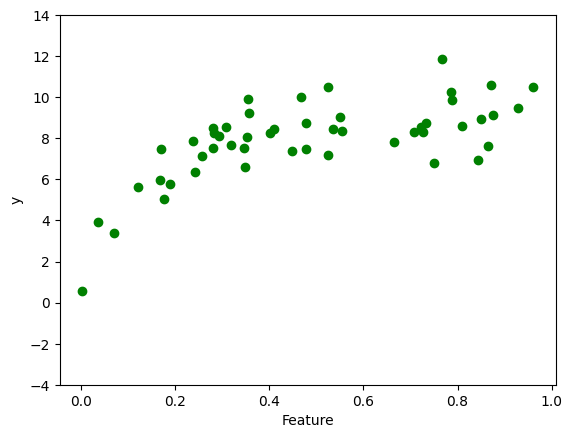

In [11]:
# Plot it so you can see what it looks like
def scatter_plot():
    fig = plt.figure()
    plt.xlabel("Feature")
    plt.ylabel("y")
    plt.ylim(-4, 14)
    plt.scatter(X_train, y_train, color = "green")
    
scatter_plot()
plt.show()

<h2>Fitting a Linear Model to the Data</h2>
<ul>
    <li>We'll use OLS Linear Regression to fit a linear model.</li>
    <li>And we'll plot the model that it learns.</li>
</ul>

In [12]:
# Create and fit the model
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
# Inference: Get its predictions for some unseen examples
X_test = np.linspace(-0.1, 1.1, 500).reshape(500, 1) 
y_predicted = linear_model.predict(X_test)

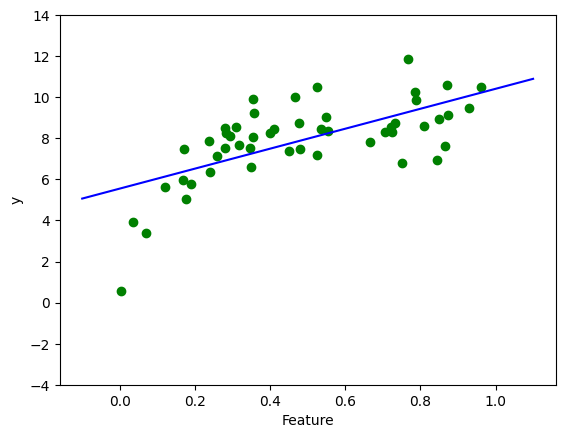

In [14]:
# Plot the training set and also the predictions made by the model
scatter_plot()
plt.plot(X_test, y_predicted, color = "blue")
plt.show()

<ul>
    <li>It's easy to see that a linear model is a poor choice.</li>
    <li>It <b>underfits</b> the data:
        <ul>
            <li>The model is not complex enough: it is too simple to capture the underlying structure of
                the data.
            </li>
        </ul>
    </li>
</ul>

<h2>Fitting a Quadratic Model to the Data</h2>
<ul>
    <li>What happens if we try to fit a more complex model such as a quadratic function?</li>
</ul>

In [15]:
# Create and fit the model
quadratic_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("predictor", LinearRegression())
])

quadratic_model.fit(X_train, y_train)

,steps,"[('poly', ...), ('predictor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [16]:
# Inference: Get its predictions
y_predicted = quadratic_model.predict(X_test)

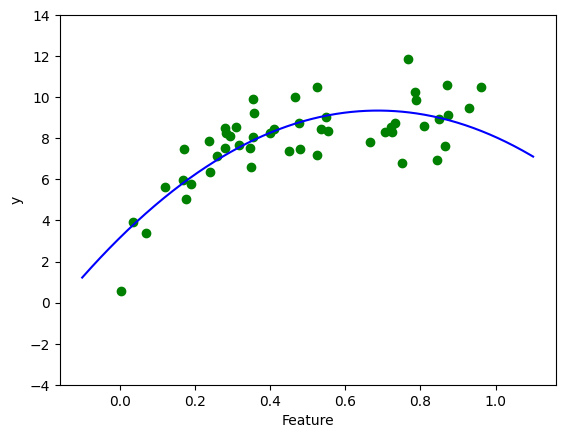

In [17]:
# Plot the training set and also the predictions made by the model on the validation set
scatter_plot()
plt.plot(X_test, y_predicted, color = "blue")
plt.show()

<ul>
    <li>This fits the training data much better: it underfits less.</li>
    <li>We could now try a cubic model&hellip;</li>
    <li>But let's skip all that and try something much more complex&hellip;</li>
</ul>

<h2>Fitting a Much Higher Degree Polynomial to the Data</h2>
<ul>
    <li>So what happens if we fit a polynomial of degree 30?</li>
</ul>

In [18]:
# Create and fit the model
poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=30, include_bias=False)),
    ("predictor", LinearRegression())
])

poly_model.fit(X_train, y_train)

,steps,"[('poly', ...), ('predictor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,30
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [19]:
# Inference: Get its predictions
y_predicted = poly_model.predict(X_test)

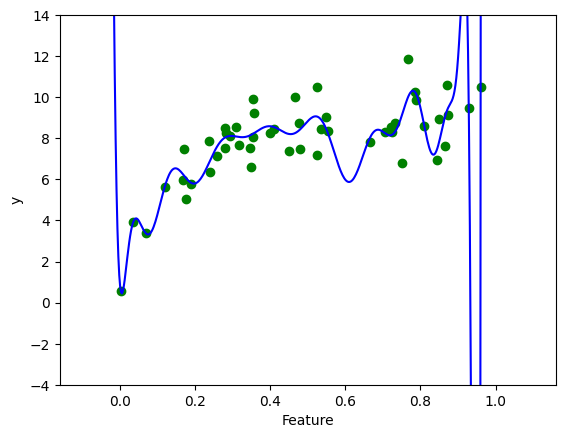

In [20]:
# Plot the training set and also the predictions made by the model on the validation set
scatter_plot()
plt.plot(X_test, y_predicted, color = "blue")
plt.show()

<ul>
    <li>While a model of this complexity fits the training set really well, it seems clear that this model is a
        poor choice.
    </li>
    <li>It is not capturing the target function; it is fitting to the noise in the training set.</li>
    <li>It <b>overfits</b> the data:
        <ul>
            <li>The model is too complex relative to the amount of training data and the noisiness of the
                training data.
            </li>
        </ul>
    </li>
</ul>

<h2>Fitting Models of Different Complexities to the Data</h2>
<ul>
    <li>We can plot complexity along the $x$-axis.
        <ul>
            <li>In our case, we plot the degree of the polynomial along the $x$-axis.</li>
        </ul>
    </li>
    <li>We can plot loss (MSE) or error (MAE) on the $y$-axis.
        <ul>
            <li>We'll plot error (MAE).</li>
            <li>In fact, we'll plot two lines: training error and validation error.</li>
        </ul>
    </li>
    Such a plot is called a <b>validation curve</b>.
</ul>

In [21]:
# I'll make a larger dataset than the one I used above 
# because I want to split this one into training and validation sets using k-fold cross-validation
X, y = make_dataset(100, f, 1.0)

In [22]:
degrees = np.arange(1, 30)

poly_model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("predictor", LinearRegression())
])

maes_train, maes_val = validation_curve(
    poly_model, X, y, param_name="poly__degree", param_range=degrees, cv=10, scoring="neg_mean_absolute_error")

mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

In [23]:
# Plot the validation curve
def plot_validation_curve(x_range, invert_axis=False):
    fig = plt.figure()
    ax = plt.axes()
    plt.xlabel("complexity")
    if invert_axis:
        ax.invert_xaxis()
    plt.ylabel("MAE")
    plt.ylim(0, 1.5)
    plt.plot(x_range, mean_maes_train, label = "training error", color = "red")
    plt.plot(x_range, mean_maes_val, label="validation error", color = "gold")
    plt.legend()

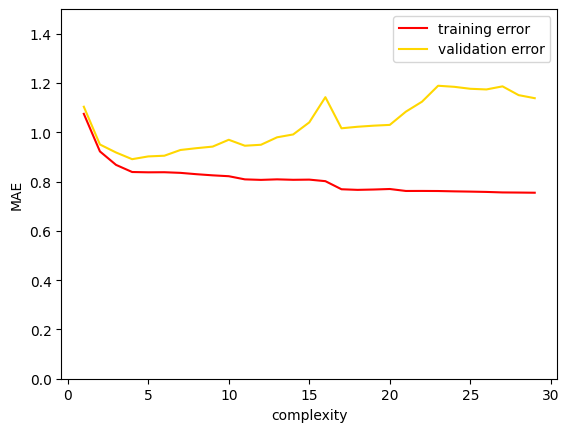

In [24]:
plot_validation_curve(x_range=degrees)
plt.show()

<ul>
    <li>We might get different results each time we run the code, but typically&hellip;</li>
    <li>Training error starts high and gets ever lower: the more complex models can wiggle their
        way through the noise in the data.
    </li>
    <li>Validation error starts high, gets lower, and then grows again (but somewhat erratically).</li>
    <li>The simpler models to the left underfit, so validation error (and training error) are high.</li>
    <li>The more complex models to the right overfit:
        <ul>
            <li>The training error is low: the more complex models can wiggle their way through the noise
                in the data.
            </li>
            <li>The validation error is high (but variable): the models don't generalise from the training data to
                the validation data.
            </li>
            <li>Between the two, the complexity is 'just right'.</li>
        </ul>
    </li>
</ul>

<ul>
    <li>We can do another example using kNN.</li>
    <li>While polynomial models get more complex as their degree gets larger, kNN is more complex as $k$
        gets smaller!
    </li>
</ul>

In [25]:
k_vals = np.arange(1, 50)

knn_model = KNeighborsRegressor() # Only one feature, so no need to scale

maes_train, maes_val = validation_curve(
    knn_model, X, y, param_name="n_neighbors", param_range=k_vals, cv=10, scoring="neg_mean_absolute_error")

mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

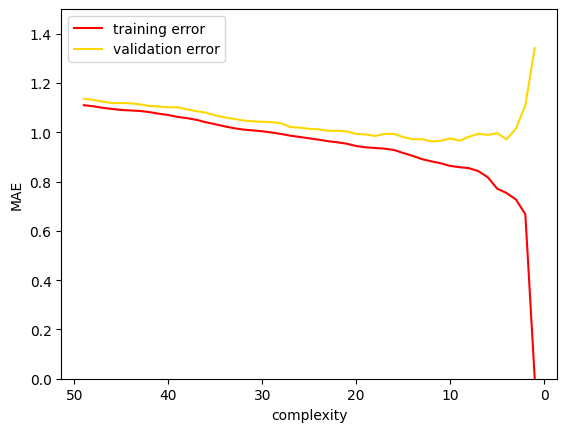

In [26]:
plot_validation_curve(x_range=k_vals, invert_axis=True)
plt.show()

<ul>
    <li>Suppose the training set contains $m$ distinct examples.</li>
    <li>The <em>training error</em> for kNN with $k=1$ will be zero. Why?</li>
</ul>

<h2>Summary of the Definitions</h2>
<ul>
    <li>A model underfits the training set if there is a more complex model with lower validation error.
    </li>
    <li>A model overfits the training set if there is a less complex model with lower validation error.
    </li>
    <li>This summary also suggests the remedies:
        <ul>
            <li>If your model underfits, then make it more complex.</li>
            <li>If you model overfits, then make it less complex.</li>
        </ul>
        How we do this is the topic of the next lecture.
    </li>
</ul>

<h1>Underfitting and Overfitting: Diagnosis</h1>
<ul>
    <li>Validation curves are useful for explaining the definitions of under- and overfitting. But they do
        not tell you whether your model is underfitting or overfitting. So you are uinlikely to ever
        draw a validation curve.
    </li>
    <li>In that case, how do you tell whether a particular model is underfitting or overfitting?</li>
    <li>We'll look at two methods:
        <ul>
            <li>Compare training error and validation error;</li>
            <li>Plot a <b>learning curve</b>.</li>
        </ul>
        In practice, people tend to use the first of these two methods because the second is expensive.
    </li>
</ul>

<h2>Compare training error and validation error</h2>
<ul>
    <li>The simplest method is to compute the training error and validation error.</li>
    <li>If a model has high training error and high validation error, then it is underfitting.</li>
    <li>If a model has low training error but high validation error, then it is overfitting.</li>
    <li>Of course, this does require a sense of what it means for error to be high or low. For this,
        a discussion with a domain expert can be useful.
    </li>
</ul>

<ul>
    <li>To compute both training error as well as validation error, use scikit-learn's 
        <code>cross_validate</code> function in place of <code>cross_val_score</code>. It returns
        a dictionary of results.
    </li>
</ul>

In [27]:
# Underfitting
# Linear regression underfits our synthetic training set.
# Note how high both kinds of error are. 
# (For the synthetic dataset that we created, error of about 0.76 is expected.)

linear_model = LinearRegression()

scores = cross_validate(linear_model, X, y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  1.0750352650507509
Validation error:  1.103829028150011


In [28]:
# Overfitting
# Polynomial regression with degree 30 overfits our synthetic training set.
# Note how low training error is, but validation error is high.

poly_model_d30 = Pipeline([
    ("poly", PolynomialFeatures(degree=30, include_bias=False)),
    ("predictor", LinearRegression())
])

scores = cross_validate(poly_model_d30, X, y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  0.7543049548936956
Validation error:  1.125311826226405


In [29]:
# Just right
# Polynomial regression with degree 4 is about right for our synthetic training set.
# Note how training error is low but not surprisingly so, and validation error is similar.

quartic_model = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("predictor", LinearRegression())
])

scores = cross_validate(quartic_model, X, y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  0.8389372649932696
Validation error:  0.8910036485833231


<h2>Plot a learning curve</h2>
<ul>
    <li><b>Learning curves</b> plot training error and validation error against the <em>number of examples 
        in the training set</em>.
    </li>
    <li>But they are expensive to produce.</li>
</ul>

In [30]:
def plot_learning_curve(ymax=1.5):
    fig = plt.figure()
    plt.xlabel("num. training examples")
    plt.ylabel("MAE")
    plt.ylim(0, ymax)
    plt.plot(train_sizes, mean_maes_train, label = "training error", color = "purple")
    plt.plot(train_sizes, mean_maes_val, label = "validation error", color = "orange")
    plt.legend()

In [31]:
train_set_sizes = np.linspace(.1, 1.0, 10)

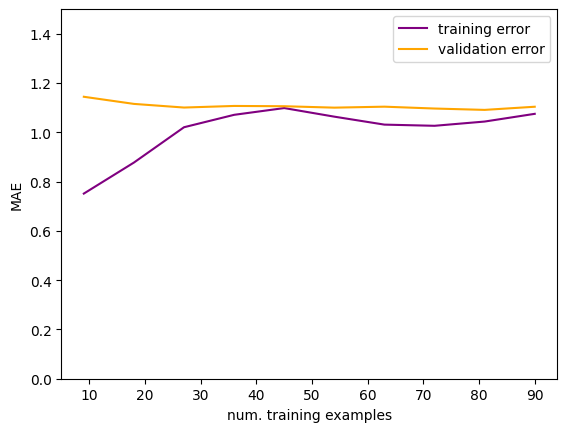

In [32]:
# Underfitting

train_sizes, maes_train, maes_val = learning_curve(linear_model, X, y, train_sizes=train_set_sizes, 
                                                    cv=10, scoring="neg_mean_absolute_error")
mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

<ul>
    <li>Training error:
        <ul>
            <li>When there are just a few training examples, the model can fit them near perfectly, which is 
                why the curve starts low.
            </li>
            <li>As more examples are used for training, it becomes impossible for the model to fit the data 
                both because of the noise but because the model isn't complex enough.
            </li>
            <li>The curve goes up and eventually plateaus.</li>
        </ul>
    </li>
    <li>Validation error:
        <ul>
            <li>When there are few training examples, the model cannot generalize well, so validation error is high.
            </li>
            <li>As more examples are used for training, the model is better so validation error comes down.</li>
            <li>But, since the model isn't complex enough, eventually validation error plateaus, very close to the
                training error.
            </li>
        </ul>
    </li>   
</ul>

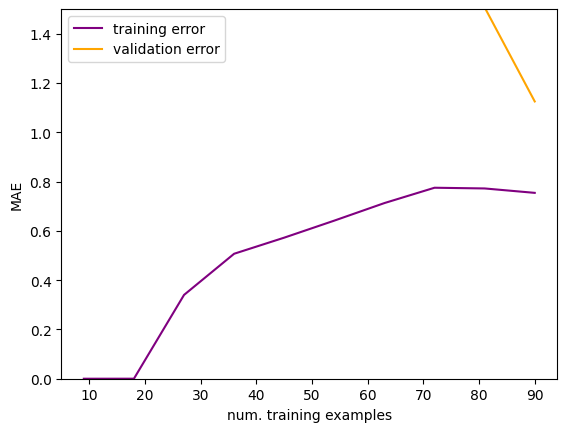

In [33]:
# Overfitting

train_sizes, maes_train, maes_val = learning_curve(poly_model_d30, X, y, train_sizes=train_set_sizes, 
                                                    cv=10, scoring="neg_mean_absolute_error")
mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

<ul>
    <li>(The validation error may be so high that it is not visible on the graph above.)</li>
    <li>These curves often have a similar shape to the case of underfitting except&hellip;
    </li>
    <li>Training error:
        <ul>
            <li>This is much lower because the model can wiggle its way through the noise.</li>
        </ul>
    </li>
    <li>Validation error:
        <ul>
            <li>There remains a big gap between training error and validation error
                (although they may get closer if we had even more training examples).
            </li>
        </ul>
    </li>
</ul>

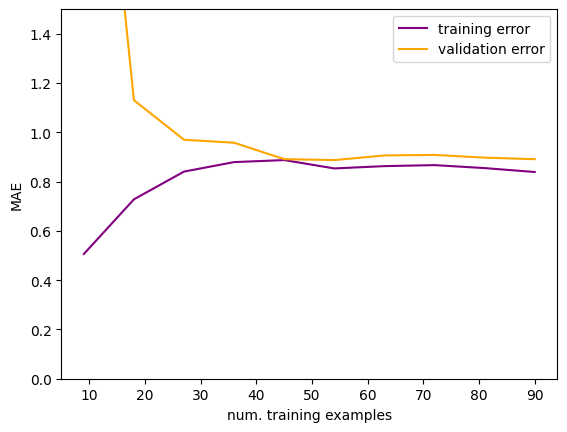

In [34]:
# Just right

train_sizes, maes_train, maes_val = learning_curve(quartic_model, X, y, train_sizes=train_set_sizes, 
                                                    cv=10, scoring="neg_mean_absolute_error")
mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

<ul>
    <li>The same kind of shape again&hellip;</li>
    <li>But, this time, the gap narrows and they should converge.</li>
</ul>

<h2>Example</h2>
<ul>
    <li>It's obvious that linear regression underfits the Cork Property Prices Dataset: who would want a
        program for predicting selling prices that is wrong on average by &euro;60,000?
    </li>
</ul>

In [35]:
# Extract the features but leave as a DataFrame
X = df[features]

# Target values, converted to a 1D numpy array
y = df["price"].values

scores = cross_validate(linear_model, X, y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  59.54976554274325
Validation error:  60.79942430798836


<ul>
    <li>So what to we do to remedy this?</li>
    <li>Go to next lecture!</li>
</ul>

<h1>Appendix</h1>
<h2>A little humourous speculation</h2>
<ul>
    <li>AI models may overfit their training dataset.</li>
    <li>Do humans overfit?</li>
    <li>If we say (somewhat loosely) that overfitting is spotting patterns where there are none, then we can find lots of examples of human overfitting.
        <ul>
            <li>When you look into the sky, do you see animals in the shapes of the clouds?</li>
            <li>A gambler's superstitions are spurious patterns that become ever more elaborate each time they lose: I win when I wear my lucky underpants, touch my head three times with my left hand and kiss a black cat.</li>
            <li>You are trying too hard to find patterns if you think there are Satanic messages in a song played backwards.</li>
        </ul>
    </li>
</ul>